<a href="https://colab.research.google.com/github/cabb1808/ProyectoSenales3/blob/main/Proyecto_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [270]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
import scipy as sp


In [271]:
!wget 'https://raw.githubusercontent.com/cabb1808/ProyectoSenales3/main/TRM.csv' -O 'TRM.csv'

--2023-06-06 23:59:09--  https://raw.githubusercontent.com/cabb1808/ProyectoSenales3/main/TRM.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 220043 (215K) [text/plain]
Saving to: ‘TRM.csv’

TRM.csv             100%[===================>] 214.89K  --.-KB/s    in 0.06s   

2023-06-06 23:59:09 (3.69 MB/s) - ‘TRM.csv’ saved [220043/220043]



In [272]:
#Importamos la database y ordenamos en orden cronologico ya que no lo está

data = pd.read_csv('TRM.csv')
# Convertir la columna de fechas al formato de fecha adecuado
data['VIGENCIADESDE'] = pd.to_datetime(data['VIGENCIADESDE'], format='%d/%m/%Y')

# Ordenar los datos por fecha
data.sort_values(by='VIGENCIADESDE', inplace=True)
datos = data[['VIGENCIADESDE', 'VALOR']]

datos['VIGENCIADESDE'] = pd.to_datetime(datos['VIGENCIADESDE'])
datos = datos.set_index('VIGENCIADESDE')

d = datos.resample('D').asfreq()


d['VALOR'].fillna(method='ffill', inplace=True)

print(d)

                 VALOR
VIGENCIADESDE         
1991-12-02      643.42
1991-12-03      639.22
1991-12-04      635.70
1991-12-05      631.51
1991-12-06      627.16
...                ...
2022-07-16     4395.63
2022-07-17     4395.63
2022-07-18     4395.63
2022-07-19     4315.41
2022-07-20     4303.34

[11189 rows x 1 columns]


<ipython-input-272-08c0800670b4>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datos['VIGENCIADESDE'] = pd.to_datetime(datos['VIGENCIADESDE'])


DatetimeIndex(['1991-12-02', '1991-12-03', '1991-12-04', '1991-12-05',
               '1991-12-06', '1991-12-07', '1991-12-08', '1991-12-09',
               '1991-12-10', '1991-12-11',
               ...
               '2022-07-11', '2022-07-12', '2022-07-13', '2022-07-14',
               '2022-07-15', '2022-07-16', '2022-07-17', '2022-07-18',
               '2022-07-19', '2022-07-20'],
              dtype='datetime64[ns]', name='VIGENCIADESDE', length=11189, freq='D')
(10629,)


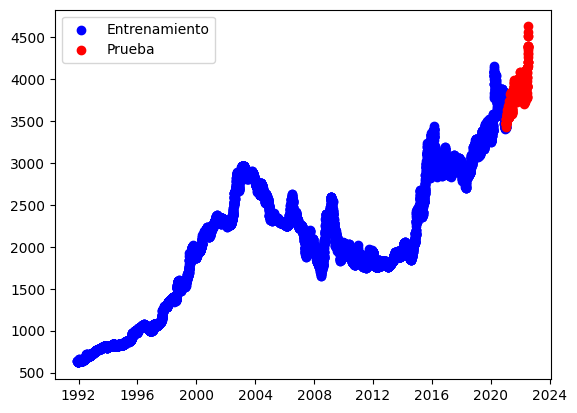

In [273]:
#Creamos un vector temporal y separamos los datos en train y test


#x = np.arange(0, 11189/1000, 0.001)
x = d.index
print(x)
X_train, X_test, y_train, y_test = train_test_split(x, d['VALOR'], test_size=0.05,shuffle=False)


print(X_train.shape)

plt.scatter(X_train, y_train, color='blue', label='Entrenamiento')
plt.scatter(X_test, y_test, color='red', label='Prueba')
plt.xlabel('')
plt.ylabel('')
plt.title('')
plt.legend()


In [277]:
model = LinearRegression()

# Entrenar el modelo
model.fit(X_train, y_train)

# Datos de prueba

# Realizar predicciones
y_pred = model.predict(X_test)

# Imprimir las predicciones
plt.plot(y_pred)
plt.xlim([0,100])

ValueError: ignored

In [278]:
def expo_carac(X, K):
    # Extraer caracteristicas exponenciales
    # X: N x D, vector de entradas 
    # K: escalar, grado del polinomio
    # return: N x (K+1), matriz de características Phi 
    
    X = X.flatten()
    N = X.shape[0]
    
    #inicializar Phi
    Phi = np.ones((N, K+1))
    mu = np.linspace(0,10,K)
    sig2 = 0.1

    # Calcular matriz Phi
    for k in range(1, K+1):
        Phi[:,k] = np.exp(-(mu[k-1] - X)**2/sig2) 
    return Phi

def cos_carac(X, K):
    # Extraer caracteristicas sinusoidales
    # X: N x D, vector de entradas 
    # K: escalar, grado del polinomio
    # return: N x (K+1), matriz de características Phi 
    
    X = X.flatten()
    N = X.shape[0]
    
    #inicializar Phi
    Phi = np.ones((N, K+1))
    F0= 0.1
    F = F0 * np.linspace(1, K, K)
 
    # Calcular matriz Phi
    for k in range(1, K+1):
      if k%2 ==0:
        Phi[:,k] = np.cos(2*np.pi*F[k-1]*X) 
      else:
        Phi[:,k] = np.sin(2*np.pi*F[k-1]*X)
    return Phi
def trig_carac(X, K):
    # Extraer caracteristicas sinusoidales
    # X: N x D, vector de entradas 
    # K: escalar, grado del polinomio
    # return: N x (K+1), matriz de características Phi 
    
    X = X.flatten()
    N = X.shape[0]
    
    #inicializar Phi
    Phi = np.ones((N, K+1))
    F0= 0.1
    F = F0 * np.linspace(1, K, K)
 
    # Calcular matriz Phi
    for k in range(1, K+1):
      if k%2 ==0:
        Phi[:,k] = np.cos(2*np.pi*F[k-1]*X) 
      else:
        Phi[:,k] = np.sin(2*np.pi*F[k-1]*X)
    return Phi

def sin_carac(X, K):
    # Extraer características senoidales
    # X: N x D, vector de entradas 
    # K: escalar, grado del polinomio
    # return: N x (K+1), matriz de características Phi 
    
    X = X.flatten()
    N = X.shape[0]
    
    # Inicializar Phi
    Phi = np.ones((N, K+1))
    F0 = 0.1
    F = F0 * np.linspace(1, K, K)
 
    # Calcular matriz Phi
    for k in range(1, K+1):
        Phi[:, k] = np.sin(2*np.pi*F[k-1]*X) 
    
    return Phi


def cos_carac(X, K):
    # Extraer características cosenoidales
    # X: N x D, vector de entradas 
    # K: escalar, grado del polinomio
    # return: N x (K+1), matriz de características Phi 
    
    X = X.flatten()
    N = X.shape[0]
    
    # Inicializar Phi
    Phi = np.ones((N, K+1))
    F0 = 0.1
    F = F0 * np.linspace(1, K, K)
 
    # Calcular matriz Phi
    for k in range(1, K+1):
        Phi[:, k] = np.cos(2*np.pi*F[k-1]*X) 
    
    return Phi

def sigmo_carac(X, K):

    X = X.flatten()
    N = X.shape[0]
    
    #inicializar Phi
    Phi = np.ones((N, K+1))
    mu = np.linspace(0,10,K)
    # Calcular matriz Phi
    for k in range(1,K+1):
      Phi[:,k] = 1/(1 + np.exp(-X + mu[k-1])) 
    return Phi

def log_carac(X, K):
    # Extraer características logarítmicas
    # X: N x D, vector de entradas 
    # K: escalar, grado del polinomio
    # return: N x (K+1), matriz de características Phi 
    
    X = X.flatten()
    N = X.shape[0]
    
    # Inicializar Phi
    Phi = np.ones((N, K+1))
    mu = np.linspace(0, 10, K)
    sig2 = 0.1

    # Calcular matriz Phi
    for k in range(1, K+1):
        Phi[:, k] = np.log(1 + np.abs(mu[k-1] - X) / sig2) 
        
    return Phi


In [279]:
def inferencia_max_vero_carac(Phi, y):
    # máxima verosimilitud usando caracteristicas
    # Phi: N x D, caracteristicas
    # y: N x 1, datos de salida observados
    # return: D x 1, vector de parametros estimados 
    
    kappa = 1e-09 # jitter
    D = Phi.shape[1]  
    
    Pt = Phi.T @ y # Phi^T*y
    PP = Phi.T @ Phi + kappa*np.eye(D) # Phi^T*Phi + kappa*I
    C = sp.linalg.cho_factor(PP)
    theta_ml = sp.linalg.cho_solve(C, Pt) # inv(Phi^T*Phi)*Phi^T*y 
    return theta_ml

In [280]:
# Aplicar PCA
pca = PCA(n_components=1)
X_train_pca = pca.fit_transform(X_train)

ValueError: ignored

In [ ]:
K = 10

Phi_expo = log_carac(X_train_pca, K)
Phi_cos = cos_carac(X_train_pca, K)
Phi_sigmo = sigmo_carac(X_train_pca, K)

# inferencia usando max vero

theta_expo = inferencia_max_vero_carac(Phi_expo, y_train)
theta_cos = inferencia_max_vero_carac(Phi_cos, y_train)
theta_sigmo = inferencia_max_vero_carac(Phi_sigmo, y_train)


# predicción sobre todos los datos 
Phi_test_expo = log_carac(x, K) # características todos los datos
Phi_test_cos = cos_carac(x, K) # características todos los datos
Phi_test_sigmo = sigmo_carac(x, K) # características todos los datos

y_predexpo = Phi_test_expo @ theta_expo
y_predcos = Phi_test_cos @ theta_cos
y_predsigmo = Phi_test_sigmo @ theta_sigmo

plt.scatter(X_train, y_train, color='blue', label='Entrenamiento')
plt.scatter(X_test, y_test, color='red', label='Prueba')
plt.plot(x, y_predsigmo, color='green', label='Predicción')
plt.show()

plt.scatter(X_train, y_train, color='blue', label='Entrenamiento')
plt.scatter(X_test, y_test, color='red', label='Prueba')
plt.plot(x, y_predcos, color='green', label='Predicción')

plt.show()

plt.scatter(X_train, y_train, color='blue', label='Entrenamiento')
plt.scatter(X_test, y_test, color='red', label='Prueba')
plt.plot(x, y_predexpo, color='green', label='Predicción')
plt.show()


In [ ]:
# Aplicar PCA
pca = PCA(n_components=1)
X_train_pca = pca.fit_transform(X_train)

K = 200

Phi_cos = cos_carac(X_train_pca, K)

# inferencia usando max vero

theta_cos = inferencia_max_vero_carac(Phi_cos, y_train)


# predicción sobre todos los datos 
Phi_test_cos = cos_carac(x, K) # características todos los datos

y_pred = Phi_test_cos @ theta_cos

plt.scatter(X_train, y_train, color='blue', label='Entrenamiento')
plt.scatter(X_test, y_test, color='red', label='Prueba')
plt.plot(x, y_pred, color='green', label='Predicción')
plt.xlabel('Tamaño (metros cuadrados)')
plt.ylabel('Precio (miles de dólares)')
plt.legend()
plt.show()



In [281]:
pip install sktime[all_extras]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


0.1801570355512491

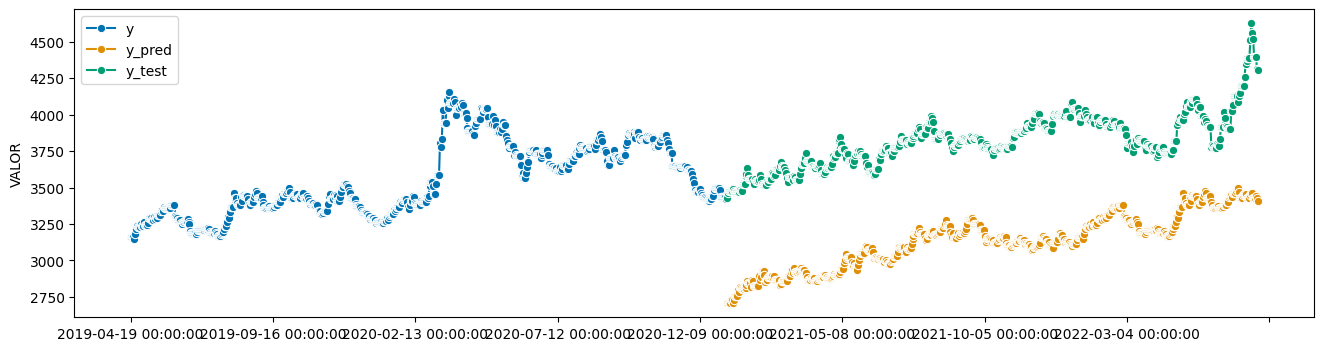

In [306]:
from sktime.utils.plotting import plot_series
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.naive import NaiveForecaster
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError , mean_absolute_percentage_error

fh = ForecastingHorizon( pd.DatetimeIndex(pd.date_range("2021-01-07", periods=560, freq="D")), is_relative=False )



X = pd.DataFrame(index=X_train)
forecaster = NaiveForecaster(strategy="last", sp=1000)

forecaster.fit(y_train, X=X, fh=fh)
y_pred = forecaster.predict(X=X)


plot_series(y_train[10000:], y_pred,y_test ,labels=["y", "y_pred","y_test"])
mean_absolute_percentage_error(y_test, y_pred, symmetric=False)